## Load Libraries

In [1]:
import cv2
import math
import numpy as np
import pandas as pd
import seaborn as sns
import skimage.measure
import matplotlib.pyplot as plt

from glob import glob
from sklearn import svm
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from skimage.feature import greycomatrix, greycoprops
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, roc_curve
%matplotlib inline

## Display Images

In [2]:
def display(img):
    plt.imshow (img, interpolation = 'nearest')
    _ = plt.axis(False)

## Remove White Background (Thresholding)

In [3]:
def remove_background(img, threshold):
    """
    This method removes background from your image
    
    :param img: cv2 image
    :type img: np.array
    :param threshold: threshold value for cv2.threshold
    :type threshold: float
    :return: RGBA image
    :rtype: np.ndarray
    """
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, threshed = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY_INV)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    morphed = cv2.morphologyEx(threshed, cv2.MORPH_CLOSE, kernel)
    
    cnts = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
    cnt = sorted(cnts, key=cv2.contourArea)[-1]

    mask = cv2.drawContours(threshed, cnt, 0, (0, 255, 0), 0)
    masked_data = cv2.bitwise_and(img, img, mask=mask)

    x, y, w, h = cv2.boundingRect(cnt)
    dst = masked_data[y: y + h, x: x + w]

    dst_gray = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(dst_gray, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(dst)

    rgba = [r, g, b, alpha]
    dst = cv2.merge(rgba, 4)
    
    dst = cv2.cvtColor(dst, cv2.COLOR_BGRA2RGB)

    return dst

## Image Folder Name

In [4]:
img_path_arr = [f"Images\\{fruit}_{ind + 1}.jpg" for fruit in ["apple", "lemon", "lychee"] for ind in range(3)]

## Convert Image to Canny

In [5]:
def convert_img_to_canny(img_path):
    img = cv2.imread(img_path)
    img = remove_background(img, threshold = 225)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
    img_canny = cv2.Canny(img_blur, 50, 150)
    return img_canny

## Generate Contour

In [6]:
img_path = "Images\\apple_1.jpg"

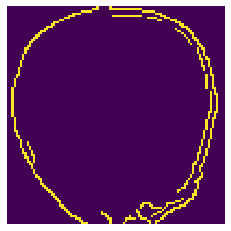

In [7]:
img = cv2.imread(img_path)
img = remove_background(img, threshold = 225)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.GaussianBlur(img_gray, (7,7), 1)
img_canny = cv2.Canny(img_blur, 50, 150)
display(img_canny)

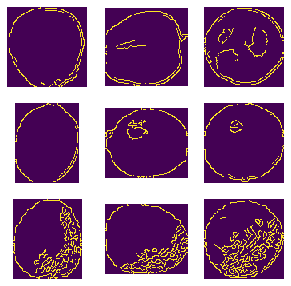

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(5,5))

img_arr = [convert_img_to_canny(img_path) for img_path in img_path_arr]

for i in range(0, 3):
    for j in range(0, 3):
        axs[i, j].imshow(img_arr[i * 3 + j], interpolation = 'nearest')
        axs[i, j].axis('off')

## Output Image Canny to Folder

In [9]:
output_path = "Image_Canny\\\\"

In [10]:
for img_path in img_path_arr:
    tmp = convert_img_to_canny(img_path)
    tmp_path = output_path + img_path.split('\\')[1]
    cv2.imwrite(tmp_path, tmp)

## Generate Hu Moments

In [11]:
def gen_hu_moment(img_canny):
    kernel = np.ones((7, 7), dtype = np.uint8)
    img_dilate = cv2.dilate(img_canny, kernel, iterations = 1)

    contours, hier = cv2.findContours(img_dilate, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    mu, huMoments = [], []
    for cnt in contours:
        mu = cv2.moments(cnt)
        huMoments = cv2.HuMoments(mu)
    
    for i in range(0,7):
        huMoments[i] = -1* math.copysign(1.0, huMoments[i]) * math.log10(abs(huMoments[i]) if abs(huMoments[i]) > 0 else 1)
    
    return {f"Hu Moment {(i + 1)}":huMoment[0] for (i, huMoment) in enumerate(huMoments)}

In [12]:
feature_arr = [f"Hu Moment {(i + 1)}" for i in range(7)]
final_df = pd.DataFrame(columns = feature_arr)
final_df

,Hu Moment 1,Hu Moment 2,Hu Moment 3,Hu Moment 4,Hu Moment 5,Hu Moment 6,Hu Moment 7


## Front View

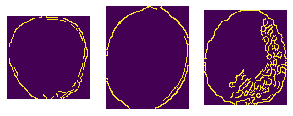

In [13]:
feature_arr = [f"Hu Moment {(i + 1)}" for i in range(7)]
final_df = pd.DataFrame(columns = feature_arr)

fig, axs = plt.subplots(1, 3, figsize=(5,5))

for (ind, img_path) in enumerate([f"Images\\{fruit}_1.jpg" for fruit in ["apple", "lemon", "lychee"]]):
    axs[ind].imshow(convert_img_to_canny(img_path), interpolation = 'nearest')
    axs[ind].axis('off')
    final_df = final_df.append(gen_hu_moment(convert_img_to_canny(img_path)), ignore_index = True)

In [14]:
final_df = final_df.T
final_df = final_df.rename(columns = {ind:val.capitalize() for (ind, val) in enumerate(["apple", "lemon", "lychee"])})

In [15]:
final_df

,Apple,Lemon,Lychee
Hu Moment 1,0.794710,-0.027950,0.788678
Hu Moment 2,4.335847,0.689861,3.205142
Hu Moment 3,4.648559,0.519662,4.322566
Hu Moment 4,7.668456,1.410814,7.017833
Hu Moment 5,-13.897716,-2.403151,-12.740638
Hu Moment 6,-10.064184,-1.871531,-8.696144
Hu Moment 7,-14.104888,-2.841355,13.021665


## Side View

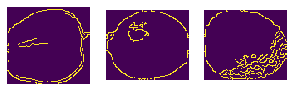

In [16]:
feature_arr = [f"Hu Moment {(i + 1)}" for i in range(7)]
final_df = pd.DataFrame(columns = feature_arr)

fig, axs = plt.subplots(1, 3, figsize=(5,5))

for (ind, img_path) in enumerate([f"Images\\{fruit}_2.jpg" for fruit in ["apple", "lemon", "lychee"]]):
    axs[ind].imshow(convert_img_to_canny(img_path), interpolation = 'nearest')
    axs[ind].axis('off')
    final_df = final_df.append(gen_hu_moment(convert_img_to_canny(img_path)), ignore_index = True)

In [17]:
final_df = final_df.T
final_df = final_df.rename(columns = {ind:val.capitalize() for (ind, val) in enumerate(["apple", "lemon", "lychee"])})

In [18]:
final_df

,Apple,Lemon,Lychee
Hu Moment 1,0.045973,0.241973,0.348364
Hu Moment 2,2.331229,2.502873,0.869137
Hu Moment 3,1.974812,3.275508,1.461540
Hu Moment 4,1.550347,1.842055,2.300075
Hu Moment 5,-3.380675,4.400839,-4.604427
Hu Moment 6,-2.909202,3.494240,-2.935502
Hu Moment 7,-3.598848,-6.915659,4.214191


## Top-Down View

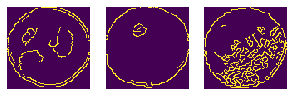

In [19]:
feature_arr = [f"Hu Moment {(i + 1)}" for i in range(7)]
final_df = pd.DataFrame(columns = feature_arr)

fig, axs = plt.subplots(1, 3, figsize=(5,5))

for (ind, img_path) in enumerate([f"Images\\{fruit}_3.jpg" for fruit in ["apple", "lemon", "lychee"]]):
    axs[ind].imshow(convert_img_to_canny(img_path), interpolation = 'nearest')
    axs[ind].axis('off')
    final_df = final_df.append(gen_hu_moment(convert_img_to_canny(img_path)), ignore_index = True)

In [20]:
final_df = final_df.T
final_df = final_df.rename(columns = {ind:val.capitalize() for (ind, val) in enumerate(["apple", "lemon", "lychee"])})

In [21]:
final_df

,Apple,Lemon,Lychee
Hu Moment 1,0.290194,-0.102574,0.796805
Hu Moment 2,4.408791,-0.009249,4.373219
Hu Moment 3,3.262780,0.316570,5.529987
Hu Moment 4,2.223147,1.130707,8.317227
Hu Moment 5,-5.137279,-1.854486,15.658201
Hu Moment 6,4.669923,-1.126194,10.504104
Hu Moment 7,-5.097766,3.448494,-15.275184
